## RNA Classification Part 2

Here, we're trying to create a dataset from the images obtained during the previous step. We're using a library called as 'Multilabelpigeon' that helps us labeling the images in an easier way

## Step 2: Creating the Dataset using the images

In [4]:
!pip install multi-label-pigeon

In [5]:
!pip install pigeon-jupyter

In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np
from fastai.vision import *

### Labeling the images, so that we avoid the false positives that are so certain.
#Unlike other cells, you can try executing this below **2 cells** alone to understand how the labeling is done. If there's an error, do try to install the libraries given in the first two cells

In [1]:
#Using multi label pigeon to label our data
from multi_label_pigeon import multi_label_annotate
from pigeon import annotate
from IPython.display import display, Image
images = []
path = ''
for i in range(0,176):
    images.append(path + str(i)+'.png')

annotations = annotate(images,
    options=['tRNA','miRNA','Neither'],
    display_fn=lambda filename: display(Image(filename))
    )

HTML(value='0 examples annotated, 177 examples left')

Output()

In [2]:
from multi_label_pigeon import multi_label_annotate
from IPython.display import display, Image
images = []
path = 'miRNA/folds/'
for i in range(0,176):
    images.append(path + str(i)+'.png')

annotations2 = annotate(images,
    options=['tRNA','miRNA','Neither'],
    display_fn=lambda filename: display(Image(filename))
    )

HTML(value='0 examples annotated, 177 examples left')

Output()

In [4]:
annotations

[('tRNA/folds/0.png', 'miRNA'),
 ('tRNA/folds/1.png', 'tRNA'),
 ('tRNA/folds/2.png', 'miRNA'),
 ('tRNA/folds/3.png', 'tRNA'),
 ('tRNA/folds/4.png', 'Neither'),
 ('tRNA/folds/5.png', 'tRNA'),
 ('tRNA/folds/6.png', 'miRNA'),
 ('tRNA/folds/7.png', 'Neither'),
 ('tRNA/folds/8.png', 'miRNA'),
 ('tRNA/folds/9.png', 'tRNA')]

### Creating a dataframe from the image name and the labels

In [37]:
names = []
labels = []
for i in annotations:
    names.append(i[0].split('/')[0]+'/'+i[0].split('/')[-1])
    labels.append(i[1])

In [38]:
for i in annotations2:
    names.append(i[0].split('/')[0]+'/'+i[0].split('/')[-1])
    labels.append(i[1])

In [44]:
data = list(zip(names,labels))
df = pd.DataFrame(data, columns=['img', 'type'])

In [45]:
df.head()

,img,type
0,tRNA/0.png,tRNA
1,tRNA/1.png,tRNA
2,tRNA/2.png,tRNA
3,tRNA/3.png,tRNA
4,tRNA/4.png,tRNA


In [46]:
df['type'].value_counts()

miRNA    176
tRNA     176
Name: type, dtype: int64

In [49]:
a  = df.to_csv ('labels.csv')

### Thus we have a dataset with images and labels, we can move on to building a model. 

# Step 3: Building the model

In [21]:
# Using the fast ai ImageDataBunch to get the data. Since we have the folder structure, not using the labels. But 
# in future, we could use the labels

In [5]:
path = 'assets/'
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='.',  valid_pct=0.2,
                                  ds_tfms=get_transforms(),num_workers=0, size=256, bs=9)

In [6]:
#Look at the classes
data.classes

['miRNA', 'tRNA']

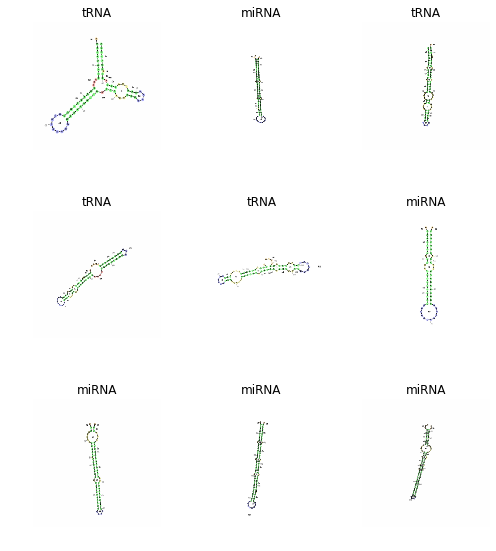

In [7]:
data.show_batch(rows=3, figsize=(7, 8))

In [8]:
#Using a pre trained model resnet (34 layer) we create a model
learn=cnn_learner(data, models.resnet34, metrics=accuracy)

In [9]:
learn.freeze()

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


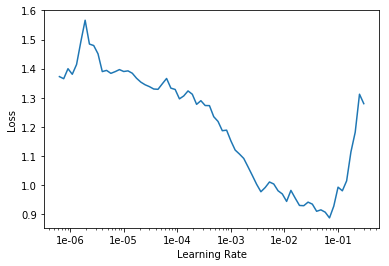

In [11]:
#We could see the curve for learning, which is not really smooth, but conisderable
learn.recorder.plot()

In [12]:
#Fit one cycle on the data, with a specific learning rate range
lr=5e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.320166,3.327554,0.666667,01:07
1,1.755873,2.612020,0.794872,01:05
2,1.673283,1.910981,0.794872,01:05
3,1.390082,1.557558,0.897436,01:04


In [13]:
learn.unfreeze()

In [14]:
lr=5e-3
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.777407,9.094500,0.564103,01:27
1,1.648594,8.073348,0.794872,01:28
2,1.408859,3.334880,0.769231,01:25
3,1.276909,1.630657,0.871795,01:25


In [15]:
#Look for the confusion matrix and observe the false positives
interp=ClassificationInterpretation.from_learner(learn)

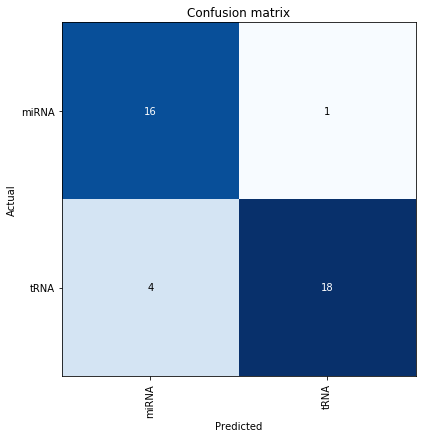

In [16]:
interp.plot_confusion_matrix(figsize=(6,6))

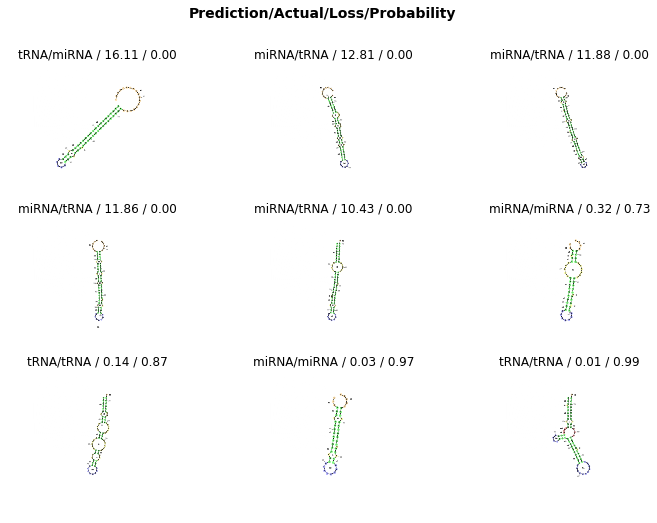

In [17]:
#Helps us to analyze how the model has performed
interp.plot_top_losses(k=9, figsize=(12, 8))

In [18]:
# We can update our dataset by removing some images
from fastai.widgets import *

ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

## Conclusion and Comments:

Though we obtained a fairly achievable model with ~90% accuracy, we face some problems in our data:

1. We can see that there are a lot of miRNA images, but a very little tRNA images. We can improve a lot, if we have some more tRNA sequences

2. We obtain the data from the gtrandb, who claim that there are some false positives in the sequence data. Thus, this could be a problem for us because when we fold those particular sequences, we won't get the clover shaped structure.

3. A lot of tRNA aren't looking like a clover shaped structure, which might be a problem that stops the model performing better.